# Register a Model Bring Your Own XGBoost training code

## 0. Configure Variables

In [5]:
import pandas as pd
import boto3
import sagemaker
from sagemaker.debugger import rule_configs, Rule, DebuggerHookConfig
from sagemaker.experiments.run import Run, load_run
sm_sess = sagemaker.session.Session()
sm_exe_role = sagemaker.get_execution_role()

boto3_sess = boto3.Session()
sm_client = boto3_sess.client('sagemaker')

aws_region = boto3_sess.region_name
aws_account_id = boto3_sess.client('sts', region_name=aws_region).get_caller_identity()["Account"]
s3_bucket = 'bring-your-own-training-code-{}-{}'.format(aws_region, aws_account_id)
s3_prefix = 'xgboost-churn'

try:
    if aws_region_name == "us-east-1":
        boto3_sess.client('s3').create_bucket(Bucket=s3_bucket)
    else:
        boto3_sess.client('s3').create_bucket(Bucket=s3_bucket, 
                                        CreateBucketConfiguration={'LocationConstraint': aws_region})
except Exception as e:
    print("Looks like you already have a bucket of this name. That's good!")

sm_xgb_framework_version = '1.7-1'
sm_xgb_image_name = sagemaker.image_uris.retrieve(framework='xgboost', region=aws_region, version=sm_xgb_framework_version)

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/sagemaker-user/.config/sagemaker/config.yaml


INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.


Looks like you already have a bucket of this name. That's good!


## 1. Data Preparation

#### Download the data and upload to S3

In [6]:
!wget https://higheredbcs.wiley.com/legacy/college/larose/0470908742/ds/data_sets.zip --no-check-certificate
!unzip -o data_sets.zip
!mv "Data sets"/churn.txt .
!rm -rf "Data sets" data_sets.zip

--2024-06-06 15:39:11--  https://higheredbcs.wiley.com/legacy/college/larose/0470908742/ds/data_sets.zip
Resolving higheredbcs.wiley.com (higheredbcs.wiley.com)... 104.18.40.34, 172.64.147.222, 2606:4700:4400::6812:2822, ...
Connecting to higheredbcs.wiley.com (higheredbcs.wiley.com)|104.18.40.34|:443... connected.
  Unable to locally verify the issuer's authority.
HTTP request sent, awaiting response... 200 OK
Length: 1003616 (980K) [application/zip]
Saving to: ‘data_sets.zip’

data_sets.zip       100%[===================>] 980.09K  --.-KB/s    in 0.1s    

2024-06-06 15:39:12 (9.54 MB/s) - ‘data_sets.zip’ saved [1003616/1003616]

Archive:  data_sets.zip
 extracting: Data sets/adult.zip     
  inflating: Data sets/cars.txt      
  inflating: Data sets/cars2.txt     
  inflating: Data sets/cereals.CSV   
  inflating: Data sets/churn.txt     
  inflating: Data sets/ClassifyRisk  
  inflating: Data sets/ClassifyRisk - Missing.txt  
 extracting: Data sets/DKD2e data sets.zip  
  inflating

In [7]:
# Convert data to CSV
import pandas as pd
data = pd.read_csv('churn.txt')
data.to_csv('churn.csv', index=False)

In [8]:
# Push to S3
local_raw_path = "churn.csv"
raw_dir = f"{s3_prefix}/data/raw"
s3uri_raw = sagemaker.s3.S3Uploader.upload(local_raw_path, f's3://{s3_bucket}/{raw_dir}')
## Store the variable
# %store s3uri_raw
s3uri_raw

's3://bring-your-own-training-code-us-east-1-047922237497/xgboost-churn/data/raw/churn.csv'

#### Import the libraries

In [9]:
import io
import os
import sys
import time
import json
import re

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from IPython.display import display as dis
from time import strftime, gmtime
from sagemaker.inputs import TrainingInput
from sagemaker.serializers import CSVSerializer
from IPython import display 

In [10]:
churn = pd.read_csv("./churn.csv")
pd.set_option("display.max_columns", 500)
churn.head(2)

,State,Account Length,Area Code,Phone,Int'l Plan,VMail Plan,VMail Message,Day Mins,Day Calls,Day Charge,Eve Mins,Eve Calls,Eve Charge,Night Mins,Night Calls,Night Charge,Intl Mins,Intl Calls,Intl Charge,CustServ Calls,Churn?
0,KS,128,415,382-4657,no,yes,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.7,1,False.
1,OH,107,415,371-7191,no,yes,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.7,1,False.


In [11]:
churn.shape

(3333, 21)

#### Change "Area Code" type and Drop columns

In [12]:
churn["Area Code"] = churn["Area Code"].astype(object)
churn = churn.drop(["Phone", "Day Charge", "Eve Charge", "Night Charge", "Intl Charge"], axis=1)

#### Convert our categorical features into numeric features and put Churn as the first column

In [13]:
model_data = pd.get_dummies(churn)
model_data = pd.concat(
    [model_data["Churn?_True."], model_data.drop(["Churn?_False.", "Churn?_True."], axis=1)], axis=1
)
model_data = model_data.astype(float)

In [14]:
model_data.shape

(3333, 70)

In [15]:
model_data.head(3)

,Churn?_True.,Account Length,VMail Message,Day Mins,Day Calls,Eve Mins,Eve Calls,Night Mins,Night Calls,Intl Mins,Intl Calls,CustServ Calls,State_AK,State_AL,State_AR,State_AZ,State_CA,State_CO,State_CT,State_DC,State_DE,State_FL,State_GA,State_HI,State_IA,State_ID,State_IL,State_IN,State_KS,State_KY,State_LA,State_MA,State_MD,State_ME,State_MI,State_MN,State_MO,State_MS,State_MT,State_NC,State_ND,State_NE,State_NH,State_NJ,State_NM,State_NV,State_NY,State_OH,State_OK,State_OR,State_PA,State_RI,State_SC,State_SD,State_TN,State_TX,State_UT,State_VA,State_VT,State_WA,State_WI,State_WV,State_WY,Area Code_408,Area Code_415,Area Code_510,Int'l Plan_no,Int'l Plan_yes,VMail Plan_no,VMail Plan_yes
0,0.0,128.0,25.0,265.1,110.0,197.4,99.0,244.7,91.0,10.0,3.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
1,0.0,107.0,26.0,161.6,123.0,195.5,103.0,254.4,103.0,13.7,3.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
2,0.0,137.0,0.0,243.4,114.0,121.2,110.0,162.6,104.0,12.2,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0


#### Split the data into training, validation, and test sets.

In [16]:
train_data, validation_data, test_data = np.split(
    model_data.sample(frac=1, random_state=1729),
    [int(0.7 * len(model_data)), int(0.9 * len(model_data))],
)
train_data.to_csv("train.csv", header=False, index=False)
validation_data.to_csv("validation.csv", header=False, index=False)
test_data.to_csv("test.csv", header=False, index=False)
train_data.shape, validation_data.shape, test_data.shape

/opt/conda/lib/python3.10/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


((2333, 70), (666, 70), (334, 70))

#### Upload these files to S3

In [17]:
boto3.Session().resource("s3").Bucket(s3_bucket).Object(
    os.path.join(s3_prefix, "train/train.csv")
).upload_file("train.csv")
boto3.Session().resource("s3").Bucket(s3_bucket).Object(
    os.path.join(s3_prefix, "validation/validation.csv")
).upload_file("validation.csv")
boto3.Session().resource("s3").Bucket(s3_bucket).Object(
    os.path.join(s3_prefix, "test/test.csv")
).upload_file("test.csv")

#### Specify TrainingInput Data

In [18]:
s3_input_train = TrainingInput(s3_data="s3://{}/{}/train".format(s3_bucket, s3_prefix), content_type="csv")
s3_input_validation = TrainingInput(s3_data="s3://{}/{}/validation/".format(s3_bucket, s3_prefix), content_type="csv")

#Store variable
# %store s3_input_train
# %store s3_input_validation

## 2. Train the model

#### Set the Experiment

In [19]:
# experiment_name
create_date = lambda: strftime("%Y-%m-%d-%H-%M-%S", gmtime())
experiment_name=f"byo-code-churn-prediction-xgboost-{create_date()}"

#### Set Debugger

In [20]:
# Set Rules for SM Debugger
debug_rules = [Rule.sagemaker(rule_configs.loss_not_decreasing()),
               Rule.sagemaker(rule_configs.overtraining()),
               Rule.sagemaker(rule_configs.overfit())
              ]

#### Set Hyperparameter

In [21]:
#Set Hyperparameter
hyperparams = {"max_depth":5,
               "subsample":0.8,
               "num_round":500,
               "eta":0.2,
               "gamma":4,
               "min_child_weight":6,
               "objective":'binary:logistic',
               "verbosity": 0
              }

#### Set the Estimator

In [22]:
from sagemaker.xgboost.estimator import XGBoost
train_script_name = 'train.py'
model_xgb = XGBoost(image_uri=sm_xgb_image_name,
                        entry_point=train_script_name,
                        role=sm_exe_role,
                        framework_version=sm_xgb_framework_version,
                        py_version="py3",
                        hyperparameters=hyperparams,
                        instance_count=1, 
                        instance_type='ml.m4.xlarge',
                        output_path=f's3://{s3_bucket}/{s3_prefix}/output',
                        base_job_name='BYO-Code-xgboost-customer-churn',
                        sagemaker_session=sm_sess,
                        rules=debug_rules
                        )


#### Fit the model - Wrapped up in Experiment Run/Trial

In [23]:
with Run(
    experiment_name=experiment_name,
    run_name=f"BYO-Code-03-framework-mode-run-{create_date()}",
    sagemaker_session=sm_sess,
) as run:
    run.log_parameters(hyperparams)
    model_xgb.fit(inputs={
                          'train': s3_input_train,
                          'validation': s3_input_validation
                             }
                     )

INFO:sagemaker.image_uris:Defaulting to the only supported framework/algorithm version: latest.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker.image_uris:Defaulting to the only supported framework/algorithm version: latest.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker.image_uris:Defaulting to the only supported framework/algorithm version: latest.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker:Creating training-job with name: BYO-Code-xgboost-customer-churn-2024-06-06-15-40-14-731


2024-06-06 15:40:15 Starting - Starting the training job...
2024-06-06 15:40:43 Starting - Preparing the instances for trainingLossNotDecreasing: InProgress
Overtraining: InProgress
Overfit: InProgress
...
2024-06-06 15:41:03 Downloading - Downloading input data...
2024-06-06 15:41:43 Downloading - Downloading the training image......
2024-06-06 15:42:44 Training - Training image download completed. Training in progress...[2024-06-06 15:42:50.082 ip-10-0-115-124.ec2.internal:7 INFO utils.py:28] RULE_JOB_STOP_SIGNAL_FILENAME: None
[2024-06-06 15:42:50.106 ip-10-0-115-124.ec2.internal:7 INFO profiler_config_parser.py:111] User has disabled profiler.
[2024-06-06:15:42:50:INFO] Imported framework sagemaker_xgboost_container.training
[2024-06-06:15:42:50:INFO] No GPUs detected (normal if no gpus installed)
[2024-06-06:15:42:50:INFO] Invoking user training script.
[2024-06-06:15:42:50:INFO] Module train does not provide a setup.py. 
Generating setup.py
[2024-06-06:15:42:50:INFO] Generating s

## 3. Model Evaluation

In [24]:
import json
import os
import tarfile
import logging

import pandas as pd
import xgboost as xgb

from sklearn import metrics

#### Get the last training Job

In [25]:
training_job_name = model_xgb.latest_training_job.job_name
training_job_name

'BYO-Code-xgboost-customer-churn-2024-06-06-15-40-14-731'

#### Download the weigths/file

In [26]:
estimator = sagemaker.estimator.Estimator.attach(training_job_name)
s3uri_model = estimator.model_data
print("\ns3uri_model =",s3uri_model)
sagemaker.s3.S3Downloader.download(s3uri_model, ".")


2024-06-06 15:48:25 Starting - Preparing the instances for training
2024-06-06 15:48:25 Downloading - Downloading the training image
2024-06-06 15:48:25 Training - Training image download completed. Training in progress.
2024-06-06 15:48:25 Uploading - Uploading generated training model
2024-06-06 15:48:25 Completed - Training job completed

s3uri_model = s3://bring-your-own-training-code-us-east-1-047922237497/xgboost-churn/output/BYO-Code-xgboost-customer-churn-2024-06-06-15-40-14-731/output/model.tar.gz


['./model.tar.gz']

#### Unzip the file

In [27]:
model_zip_file = "model.tar.gz"
with tarfile.open(model_zip_file) as tar:
    tar.extractall(path=".")

#### Load the Model

In [28]:
import xgboost as xgb
print("Loading xgboost model.")
xgb_model_file_path = "xgboost-model.json"
xgb_model = xgb.Booster()
xgb_model.load_model(xgb_model_file_path)
xgb_model

Loading xgboost model.


#### Load the Test Data on Pandas

In [29]:
print("Loading test input data")
test_path = "test.csv"
df = pd.read_csv(test_path, header=None)
df.head(3)

Loading test input data


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69
0,0.0,186.0,0.0,137.8,97.0,187.7,118.0,146.4,85.0,8.7,6.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0
1,0.0,132.0,25.0,113.2,96.0,269.9,107.0,229.1,87.0,7.1,7.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
2,0.0,112.0,17.0,183.2,95.0,252.8,125.0,156.7,95.0,9.7,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0


In [30]:
df.shape

(334, 70)

In [31]:
print("Reading test data. We should get an `DMatrix` object...")
y_test = df.iloc[:, 0].to_numpy()
df.drop(df.columns[0], axis=1, inplace=True)
X_test = xgb.DMatrix(df.values)
X_test

Reading test data. We should get an `DMatrix` object...


#### Make the prediction

In [32]:
print("Performing predictions against test data.")
y_predictions_probs = xgb_model.predict(X_test)
y_predictions = y_predictions_probs.round()

Performing predictions against test data.


In [33]:
y_predictions_probs[0:3]

array([0.01230374, 0.00619485, 0.0075826 ], dtype=float32)

In [34]:
y_predictions[0:3]

array([0., 0., 0.], dtype=float32)

#### Get the Scores/Metrics

In [35]:
# Function to get different metrics
def get_score(y_true,y_pred):
    f1 = metrics.f1_score(y_true, y_pred)
    precision = metrics.precision_score(y_true, y_pred)
    recall = metrics.recall_score(y_true, y_pred)
    accuracy = metrics.accuracy_score(y_true, y_pred)
    tn, fp, fn, tp = metrics.confusion_matrix(y_true, y_pred).ravel()
    return precision, recall, f1, accuracy, tn, fp, fn, tp

#### Main Metrics

In [36]:
precision, recall, f1, accuracy, tn, fp, fn, tp = get_score(y_test, y_predictions)
output_columns = [precision,recall,f1,accuracy,tp, fp, tn, fn]
output = pd.Series(output_columns, index=['precision', 'recall', 'f1', 'accuracy', 'tp', 'fp', 'tn', 'fn']) 
#print(output[['accuracy', 'tp', 'fp', 'tn', 'fn']])
print(output)

precision      0.902439
recall         0.770833
f1             0.831461
accuracy       0.955090
tp            37.000000
fp             4.000000
tn           282.000000
fn            11.000000
dtype: float64


In [37]:
auc = metrics.roc_auc_score(y_test, y_predictions_probs)
print("AUC =", auc)

AUC = 0.9174679487179487


#### Classification Report

In [38]:
print(metrics.classification_report(y_test, y_predictions))

              precision    recall  f1-score   support

         0.0       0.96      0.99      0.97       286
         1.0       0.90      0.77      0.83        48

    accuracy                           0.96       334
   macro avg       0.93      0.88      0.90       334
weighted avg       0.95      0.96      0.95       334



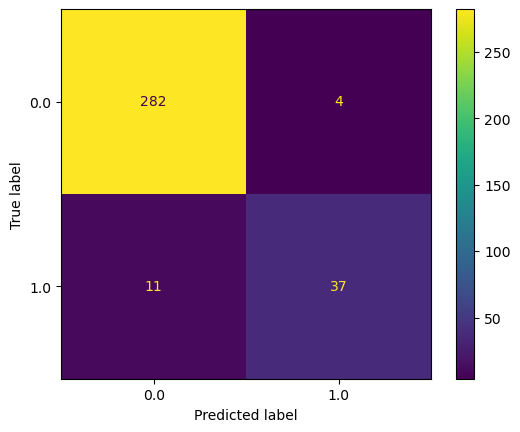

In [39]:
confusion_m = metrics.confusion_matrix(y_test, y_predictions)
# disp = ConfusionMatrixDisplay(confusion_matrix=confusion_m)
# disp.plot()
# or
metrics.ConfusionMatrixDisplay.from_predictions(y_test, y_predictions)

In [ ]:
##############

In [34]:
print("Performing predictions against test data.")
y_predictions_probs = xgb_model.predict(X_test)
y_predictions = y_predictions_probs.round()

Performing predictions against test data.


In [35]:
y_predictions_probs[0:5]

array([0.01230374, 0.00619485, 0.0075826 , 0.16445525, 0.00404909],
      dtype=float32)

In [36]:
y_predictions[0:5]

array([0., 0., 0., 0., 0.], dtype=float32)

In [33]:
print("Main metrics:")
auc = roc_auc_score(y_test, y_predictions_probs)
accuracy = accuracy_score(y_test, y_predictions)
f1 = f1_score(y_test, y_predictions)
recall = recall_score(y_test, y_predictions)
precision = precision_score(y_test, y_predictions)

print("AUC =", auc)
print("Accuracy =", accuracy)
print("F1 Score =", f1)
print("recall =", recall)
print("precision =", precision)

Main metrics:
AUC = 0.912004662004662
Accuracy = 0.9580838323353293
F1 Score = 0.8409090909090909
recall = 0.7708333333333334
precision = 0.925


#### Confusion Matrix

In [38]:
confusion_m =confusion_matrix(y_test, y_predictions)
confusion_m

array([[282,   4],
       [ 11,  37]])

In [39]:
# ConfusionMatrixDisplay.from_estimator(model_xgb,X_test,y_test)  # But only support classifier

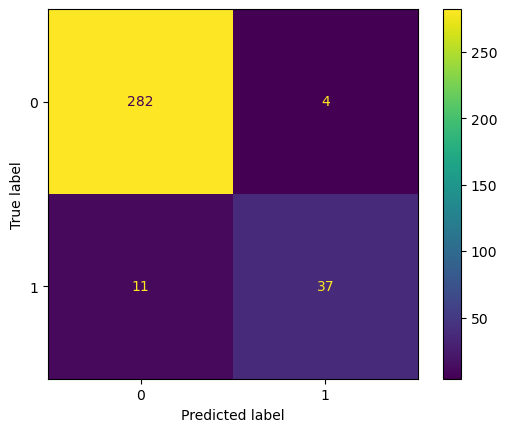

In [40]:
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_m)
disp.plot()
#ConfusionMatrixDisplay.from_predictions(y_test, y_predictions)

In [41]:
tp = confusion_m[1][1]
tp

37

In [42]:
fp = confusion_m[0][1]
fp

4

In [43]:
tn = confusion_m[0][0]
tn

282

In [44]:
fn = confusion_m[1][0]
fn

11

In [45]:
re = tp / (tp + fn)
re

0.7708333333333334

In [46]:
pec = tp / (tp + fp)
pec

0.9024390243902439

In [47]:
f1s = 2*re*pec / (re + pec)
f1s

0.8314606741573034

In [48]:
ac = (tp + tn) / (tp + tn + fp + fn)
ac

0.9550898203592815

In [4]:
#################

#### Creating the Evaluation report

In [40]:
import pprint
# The metrics reported can change based on the model used - check the link for the documentation 
report_dict = {
"binary_classification_metrics" : {
    "confusion_matrix" : {
      "0" : {
        "0" : tn.item(),
        "1" : fn.item()
      },
      "1" : {
        "0" : fp.item(),
        "1" : tp.item()
      }
    },
    "recall" : {
      "value" : recall,
      "standard_deviation" : "NaN"
    },
    "precision" : {
      "value" : precision,
      "standard_deviation" : "NaN"
    },
    "accuracy" : {
      "value" : accuracy,
      "standard_deviation" : "NaN"
    },
    "true_positive" : {
      "value" : tp.item(),
      "standard_deviation" : "NaN"
    },
    "true_negative" : {
      "value" : tn.item(),
      "standard_deviation" : "NaN"
    },
    "false_positive" : {
      "value" : fp.item() ,
      "standard_deviation" : "NaN"
    },
    "false_negative" : {
      "value" : fn.item(),
      "standard_deviation" : "NaN"
    },
    "auc" : {
      "value" : auc,
      "standard_deviation" : "NaN"
    },
    "f1" : {
      "value" : f1,
      "standard_deviation" : "NaN"
    }
  }
}

print("Classification report:")
pprint.pprint(report_dict)

Classification report:
{'binary_classification_metrics': {'accuracy': {'standard_deviation': 'NaN',
                                                'value': 0.9550898203592815},
                                   'auc': {'standard_deviation': 'NaN',
                                           'value': 0.9174679487179487},
                                   'confusion_matrix': {'0': {'0': 282,
                                                              '1': 11},
                                                        '1': {'0': 4, '1': 37}},
                                   'f1': {'standard_deviation': 'NaN',
                                          'value': 0.8314606741573034},
                                   'false_negative': {'standard_deviation': 'NaN',
                                                      'value': 11},
                                   'false_positive': {'standard_deviation': 'NaN',
                                                      'value': 4},
        

In [41]:
evaluation_output_path = os.path.join(
    ".", "evaluation-report.json"
)
print("Saving classification report to {}".format(evaluation_output_path))

with open(evaluation_output_path, "w") as f:
    f.write(json.dumps(report_dict))

Saving classification report to ./evaluation-report.json


#### Get and save parameters used to train the model

In [42]:
estimator.hyperparameters()

{'eta': '0.2',
 'gamma': '4',
 'max_depth': '5',
 'min_child_weight': '6',
 'num_round': '500',
 'objective': '"binary:logistic"',
 'sagemaker_container_log_level': '20',
 'sagemaker_job_name': '"BYO-Code-xgboost-customer-churn-2024-06-06-15-40-14-731"',
 'sagemaker_program': '"train.py"',
 'sagemaker_region': '"us-east-1"',
 'sagemaker_submit_directory': '"s3://bring-your-own-training-code-us-east-1-047922237497/BYO-Code-xgboost-customer-churn-2024-06-06-15-40-14-731/source/sourcedir.tar.gz"',
 'subsample': '0.8',
 'verbosity': '0'}

In [43]:
parameter_output_path = os.path.join(
    ".", "parameters.json"
)
print("Saving parameters used to train the model to {}".format(parameter_output_path))

with open(parameter_output_path, "w") as f:
    f.write(json.dumps(estimator.hyperparameters()))

Saving parameters used to train the model to ./parameters.json


#### Create the configuration file

In [44]:
# Container image used to train the model
estimator.training_image_uri()

'683313688378.dkr.ecr.us-east-1.amazonaws.com/sagemaker-xgboost:1.7-1'

In [45]:
import pprint
# The metrics reported can change based on the model used - check the link for the documentation 
configuration_file = {
"config" : {
    "training_image_uri" : {
        "value" : estimator.training_image_uri()    
    }
  }
}

print("Configuration file:")
pprint.pprint(configuration_file)

Configuration file:
{'config': {'training_image_uri': {'value': '683313688378.dkr.ecr.us-east-1.amazonaws.com/sagemaker-xgboost:1.7-1'}}}


In [46]:
configuration_output_path = os.path.join(
    ".", "configuration-file.json"
)
print("Saving configuration files to {}".format(configuration_output_path))

with open(configuration_output_path, "w") as f:
    f.write(json.dumps(configuration_file))

Saving configuration files to ./configuration-file.json


#### Push the Evaluation report, the test dataset, the parameters and the configuration file to S3 Bucket

In [47]:
# Push evaluation-report.json to S3
eval_report_path = "evaluation-report.json"
prefix = "final_result"
s3_location = f"s3://{s3_bucket}/{prefix}"
location = sagemaker.s3.S3Uploader.upload(eval_report_path, s3_location)
location

's3://bring-your-own-training-code-us-east-1-047922237497/final_result/evaluation-report.json'

In [48]:
#Set the prefix for the final result
final_prefix = "final_result"
s3_location = f"s3://{s3_bucket}/{final_prefix}"

In [49]:
# Push Test DataSet to S3
test_dataSet_path = "test.csv"
location = sagemaker.s3.S3Uploader.upload(test_dataSet_path, s3_location)
location

's3://bring-your-own-training-code-us-east-1-047922237497/final_result/test.csv'

In [50]:
# Push Parameters to S3
param_path = "parameters.json"
location = sagemaker.s3.S3Uploader.upload(param_path, s3_location)
location

's3://bring-your-own-training-code-us-east-1-047922237497/final_result/parameters.json'

In [51]:
# Push the configuration file to S3
config_file_path = "configuration-file.json"
location = sagemaker.s3.S3Uploader.upload(config_file_path, s3_location)
location

's3://bring-your-own-training-code-us-east-1-047922237497/final_result/configuration-file.json'

In [52]:
# Push the model weights to the same location so we have every thing n the same place
model_weights_path = "model.tar.gz"
location = sagemaker.s3.S3Uploader.upload(model_weights_path, s3_location)
location

's3://bring-your-own-training-code-us-east-1-047922237497/final_result/model.tar.gz'

#### Access the Bucket on S3

In [53]:
from IPython.display import display, HTML
s3_url_link = "https://s3.console.aws.amazon.com/s3/buckets/{}?&prefix={}/"

In [54]:
display(HTML(f"<a href={s3_url_link.format(s3_bucket,final_prefix)}>Access the Bucket on S3</a>"))

## 4. Model Registry

#### Variables needed

In [57]:
print("sm_client:", sm_client)
print("sm_xgb_image_name:", sm_xgb_image_name)
print("s3uri_model:", s3uri_model)

sm_client: <botocore.client.SageMaker object at 0x7fb14c12d4e0>
sm_xgb_image_name: 683313688378.dkr.ecr.us-east-1.amazonaws.com/sagemaker-xgboost:1.7-1
s3uri_model: s3://bring-your-own-training-code-us-east-1-047922237497/xgboost-churn/output/BYO-Code-xgboost-customer-churn-2024-06-06-15-40-14-731/output/model.tar.gz


#### Create a Model Group

In [58]:
import time
model_package_group_name = "Bring-Your-Own-Code-xgb-" + str(round(time.time()))
model_package_group_input_dict = {
 "ModelPackageGroupName" : model_package_group_name,
 "ModelPackageGroupDescription" : "Model to predict Customers that may churn"
}

create_model_package_group_response = sm_client.create_model_package_group(**model_package_group_input_dict)
print('ModelPackageGroup Arn : {}'.format(create_model_package_group_response['ModelPackageGroupArn']))

ModelPackageGroup Arn : arn:aws:sagemaker:us-east-1:047922237497:model-package-group/Bring-Your-Own-Code-xgb-1717689147


#### Register a Model Version

In [59]:
modelpackage_inference_specification =  {
    "InferenceSpecification": {
      "Containers": [
         {
            "Image": sm_xgb_image_name,
	    "ModelDataUrl": s3uri_model
         }
      ],
      "SupportedContentTypes": [ "text/csv" ],
      "SupportedResponseMIMETypes": [ "text/csv" ],
   }
 }

In [60]:
# Alternatively, we can specify the model source like this:
# modelpackage_inference_specification["InferenceSpecification"]["Containers"][0]["ModelDataUrl"]=s3uri_model

In [61]:
create_model_package_input_dict = {
    "ModelPackageGroupName" : model_package_group_name,
    "ModelPackageDescription" : "Model to predict Customers that may churn",
    "ModelApprovalStatus" : "PendingManualApproval"
}
create_model_package_input_dict.update(modelpackage_inference_specification)
create_model_package_input_dict

{'ModelPackageGroupName': 'Bring-Your-Own-Code-xgb-1717689147',
 'ModelPackageDescription': 'Model to predict Customers that may churn',
 'ModelApprovalStatus': 'PendingManualApproval',
 'InferenceSpecification': {'Containers': [{'Image': '683313688378.dkr.ecr.us-east-1.amazonaws.com/sagemaker-xgboost:1.7-1',
    'ModelDataUrl': 's3://bring-your-own-training-code-us-east-1-047922237497/xgboost-churn/output/BYO-Code-xgboost-customer-churn-2024-06-06-15-40-14-731/output/model.tar.gz'}],
  'SupportedContentTypes': ['text/csv'],
  'SupportedResponseMIMETypes': ['text/csv']}}

In [62]:
create_model_package_response = sm_client.create_model_package(**create_model_package_input_dict)
model_package_arn = create_model_package_response["ModelPackageArn"]
print('ModelPackage Version ARN : {}'.format(model_package_arn))

ModelPackage Version ARN : arn:aws:sagemaker:us-east-1:047922237497:model-package/Bring-Your-Own-Code-xgb-1717689147/1
